## 2.3. change scores response genes

In this notebook we will use the response genes that were found using R script 2.1 (`code/2.1.find_response_genes.R`). If you did not run this script you can also use the file in the Github repository that contains the top 500 response genes (`results/response_genes/response_genes_top500.csv`). 

In this analysis we are interested in quantifying the total change of each response gene per cluster. We did this by calculating a "change score". In our manuscript there is a more in-depth description of the mathematics behind the change score (it is quite simple, don't be scared to have a look). In short, it is a score between 0 and 1 that tells us how much a gene is changing in each of the clusters (relative to each other). If the score is high in all clusters, it means that the gene is changing in all of the clusters, but if it is high only in one cluster, the gene is changing mostly only in that cluster. It is important to note that change can be both an upregulation or downregulation. 

Note: in our case, each of the clusters is present in each of the timepoints. If for some reason you have clusters that physically appear or disappear in different timesteps of your time series, than make sure to remove those genes from the analysis as they will not a produce a change score that can be reliably compared to the other change scores.

In [1]:
### loading python libraries

# standard libraries
import numpy as np
import pandas as pd

# single cell libraries
import anndata as ad
import scanpy as sc
sc.settings.verbosity = 0 

# plotting libraries
from matplotlib import pyplot as plt
import matplotlib.colors as plt_colors # for converting rgb to #
plt.rcParams['pdf.fonttype'] = 42 #for saving PDF with changeable text
plt.rcParams['ps.fonttype'] = 42 #for saving PDF with changeable text

# other 
import warnings
warnings.filterwarnings('ignore') #ignore filter warnings
import sklearn as sk #used for L2 normalization
import sklearn.preprocessing #used for L2 normalization
from scipy.cluster.hierarchy import linkage, leaves_list, fcluster #for hiearchical clustering
from scipy.spatial.distance import pdist #for hiearchical clustering
from scipy.cluster import hierarchy #for hiearchical clustering
from scipy.spatial import distance #for hiearchical clustering

# import own functions
from plotting import *
from utils import *

### Load data

Here, we load the filtered HSPC dataset (as filtered in notebook 1.3) and the list of top 500 response genes.

In [2]:
### load Anndata object with the HSPC dataset (all four subsets incl.)
adata_path = "../data/count_matrices/all_filtered.h5ad"
adata = sc.read_h5ad(adata_path)

In [3]:
### L2 normalize dataset
adata.X = sk.preprocessing.normalize(adata.X, norm='l2')

In [4]:
### scale data
sc.pp.scale(adata)

In [5]:
### load top 500 response genes
response_genes_path = "../results/response_genes/response_genes_top500.csv"
response_genes = pd.read_csv(response_genes_path)
response_genes = response_genes.values.flatten() #move genes from dataframe to array

In [6]:
### get clusters
clusters = adata.obs['clusters'].cat.categories.values

### Calculate change scores
Here, we calculate for each cluster and for each response gene the expression change in all timepoints combined. The expression change in all timesteps are combined.

In [7]:
### calculate change scores for each cluster individually
change_scores = {}

for cluster in clusters:

    # get delta expression in each timestep (for all response genes)
    delta_expr = get_delta_expression(adata, response_genes, cluster=cluster)

    # calculate sum of delta expression (absolute values)
    delta_expr_sum = delta_expr.abs().sum()
    
    # add to dictionary
    change_scores[cluster] = delta_expr_sum

change_scores = pd.DataFrame.from_dict(change_scores)

In [8]:
### scale change scores between 0 and 1
change_scores = change_scores.divide(change_scores.max(axis=1), axis=0)

### Group response genes based on change scores

In the change scores table each of the 500 response genes has 14 change scores assigned, representing all 14 clusters. Next, we group the 500 response genes based on the change scores that were calculated for each cluster.

In [9]:
### get linkage
row_linkage = hierarchy.linkage(distance.pdist(change_scores), method='ward')

### get groups
groups = fcluster(row_linkage, t=3, criterion='distance')
groups = pd.Series(groups)

### add gene names to groups
groups.index = response_genes

In [10]:
### number of groups
len(np.unique(groups))

14

### Plot change scores and response gene groups

Here, we plot all 500 response genes and the groups they are assigned to in a heatmap. 

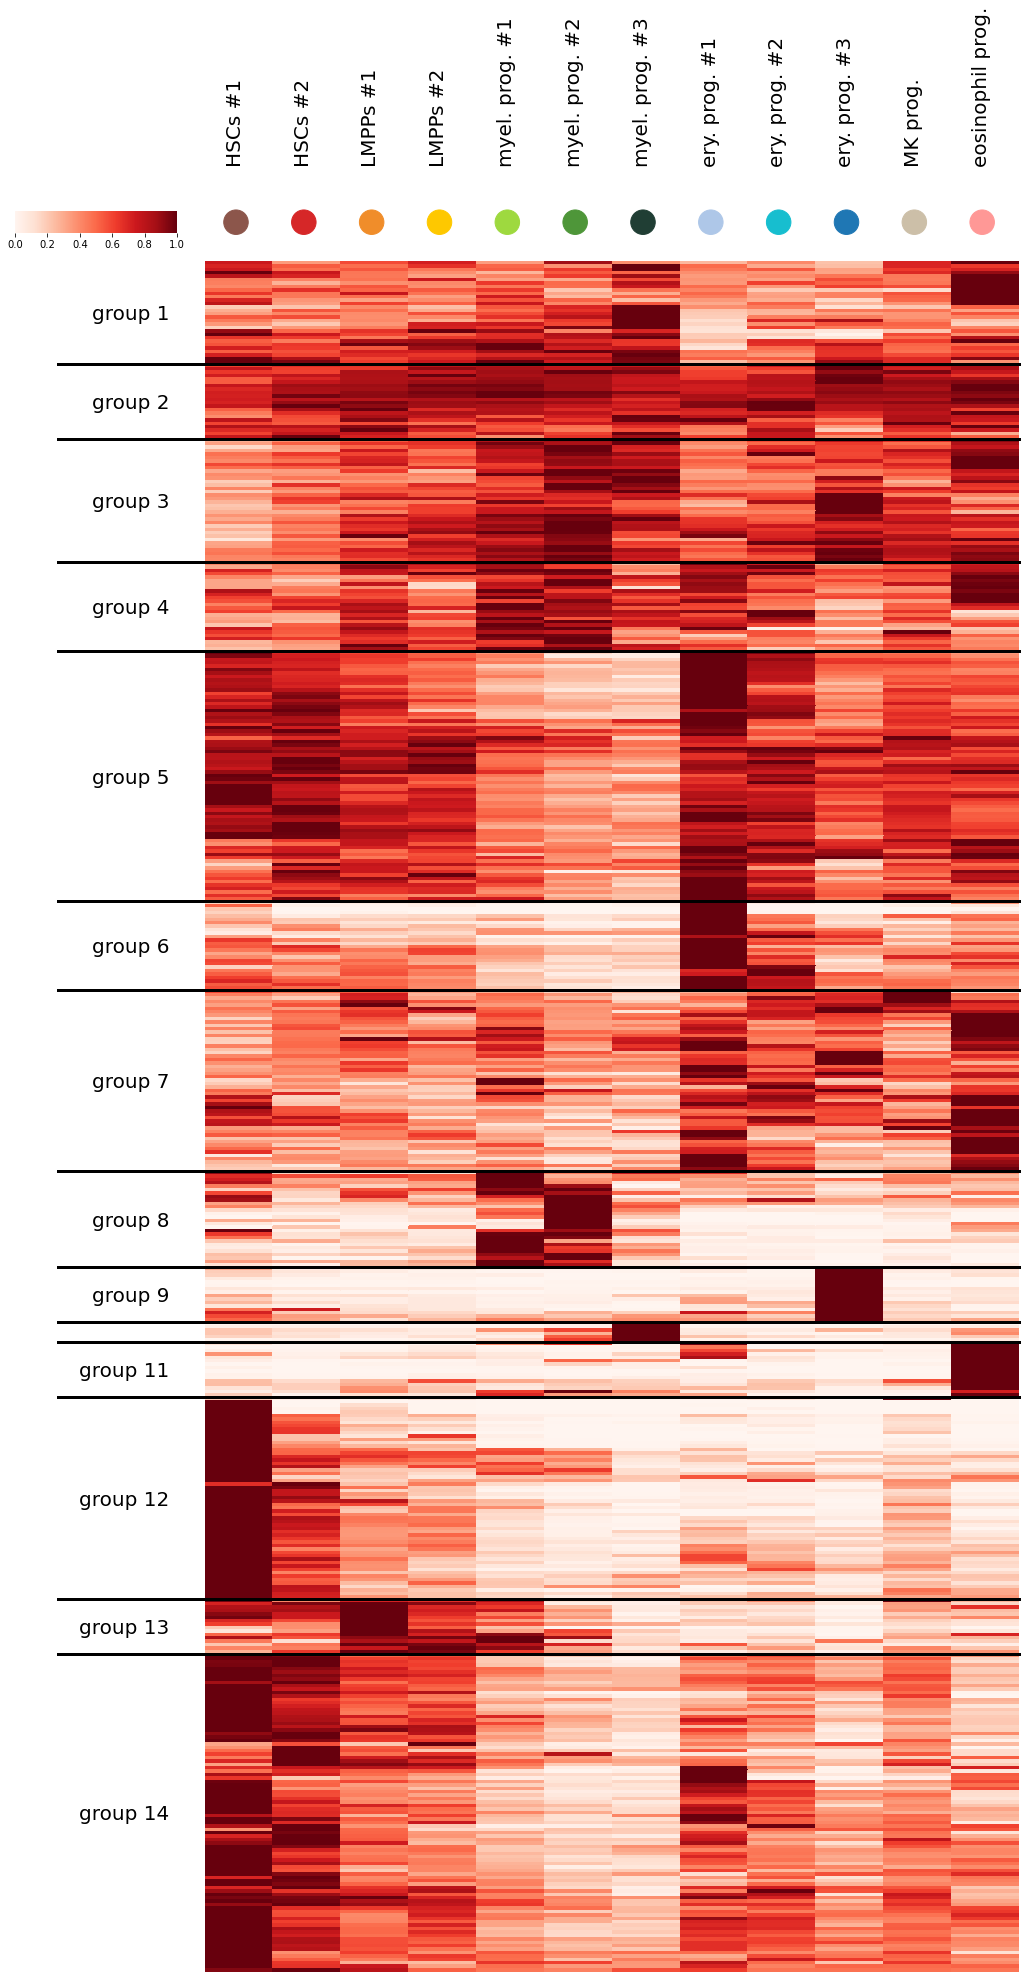

In [11]:
plot_heatmap_scores(adata, change_scores, groups, row_linkage, name="change_scores", save=True, save_path="../figures/2.3.heatmap_change_scores.pdf")

### Calculate pattern similarity

Here, we will calculate how well the expression profile of a response gene in one cluster is in concordance with the expression profile of the response gene in the complete datasets (= similarity). In order to compare just the expression profile, we will scale the expression between 0 and 1 for both the complete dataset and the individual clusters. 

In [12]:
### calculate similarity scores for each cluster individually
sim_scores = {}

for cluster in clusters:
    
    # get expression clusters
    expr_cluster = get_expression(adata, response_genes, cluster=cluster)
    
    # get expression complete dataset
    expr_all = get_expression(adata, response_genes, cluster=None)
    
    # scale both expressions between 0 and 1
    expr_cluster = (expr_cluster - expr_cluster.min())/(expr_cluster.max() - expr_cluster.min())
    expr_all = (expr_all - expr_all.min())/(expr_all.max() - expr_all.min())
    
    # get similarity score
    sim_score = 1-((expr_all.subtract(expr_cluster).abs().sum()))/4
    sim_scores[cluster] = sim_score

sim_scores = pd.DataFrame.from_dict(sim_scores)

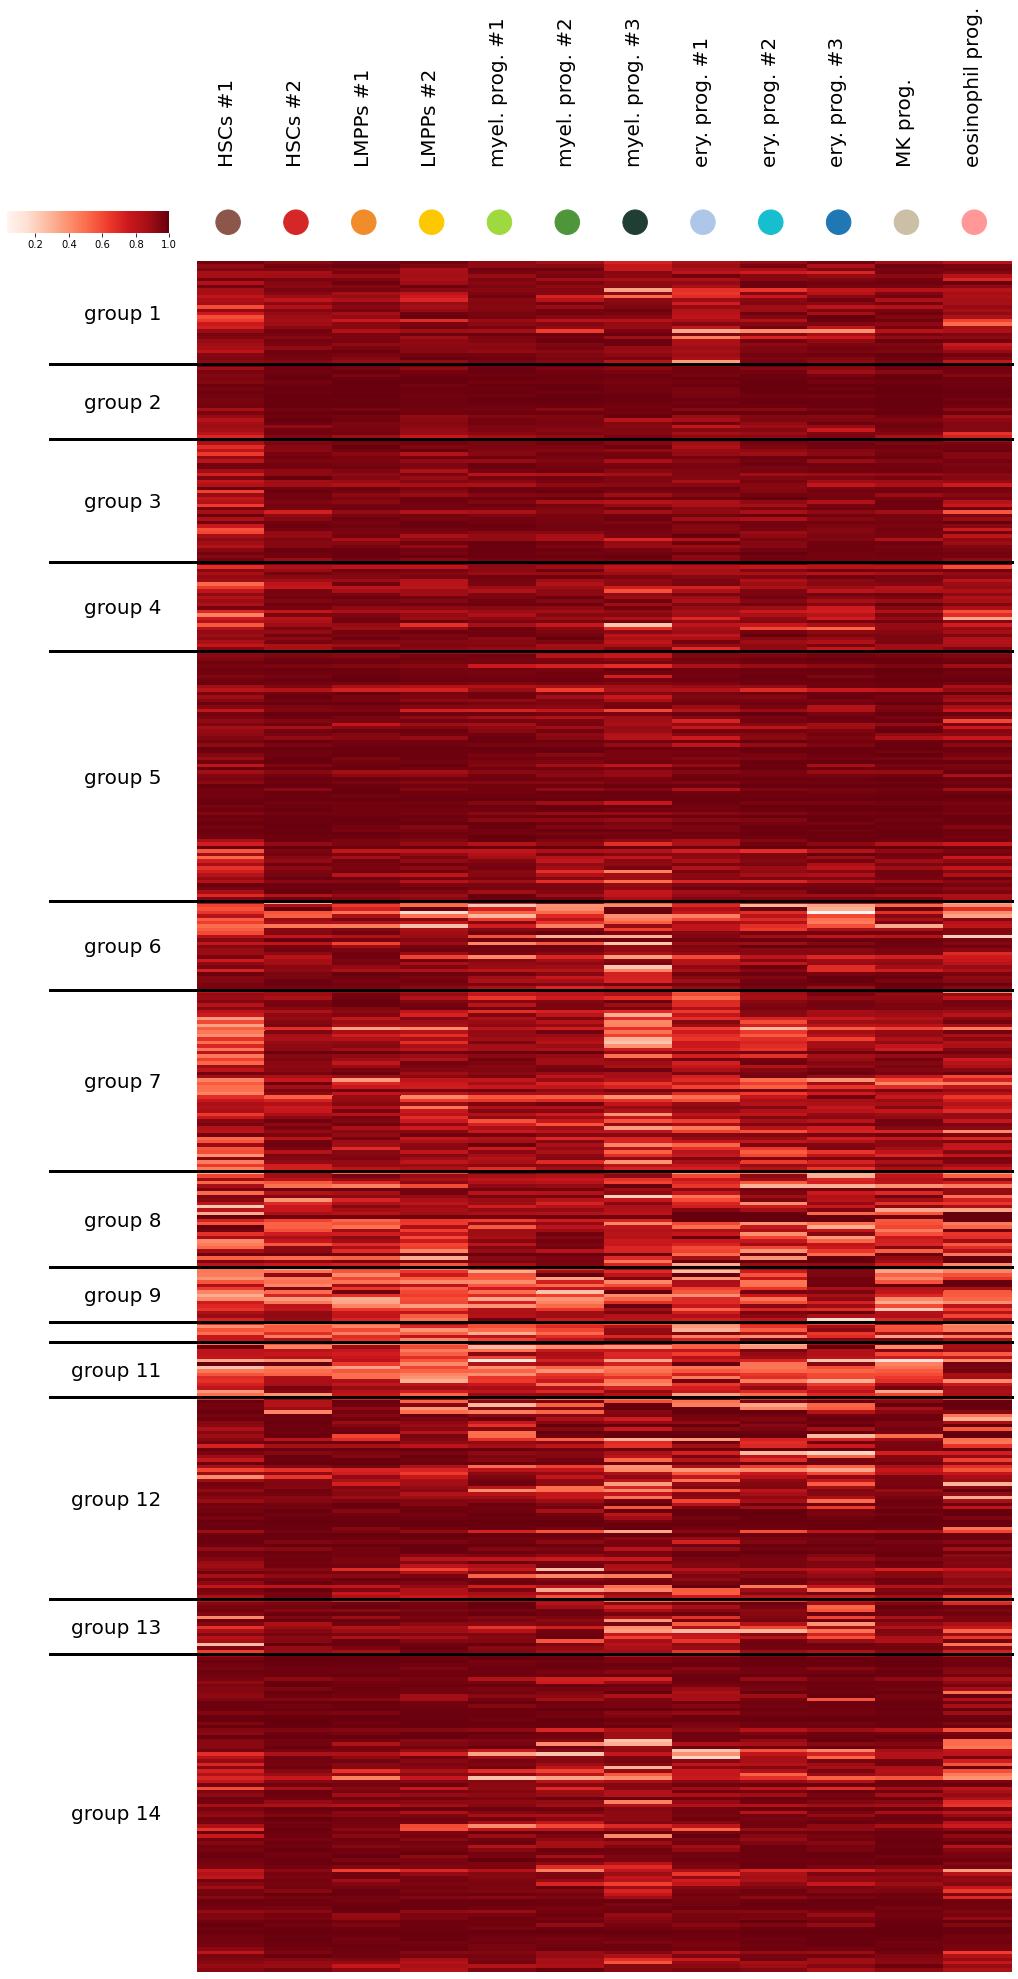

In [13]:
plot_heatmap_scores(adata, sim_scores, groups, row_linkage, name="pattern_similarity", save=True, save_path="../figures/2.3.heatmap_similarity_scores.pdf")

### Plot mean score in UMAP
To get a better understanding of the cluster specificity of each response gene group, we will plot UMAPs for every group, where we summarize the change scores found in each cluster. We do this by taking the mean change score in each cluster. 

In [14]:
### get mean scores per cluster in each group
group_scores = {}

for i in range(1, groups.max()+1):
    group_score = change_scores.loc[groups[groups == i].index.values,].mean(axis=0)
    group_scores[i] = group_score
    
group_scores = pd.DataFrame.from_dict(group_scores)

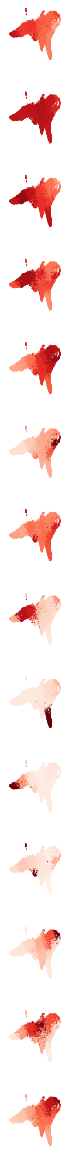

In [15]:
### create UMAP per change score group
fig, axs = plt.subplots(len(group_scores.columns),1,
                        figsize = (1,1.5*len(group_scores.columns)),
                        gridspec_kw={'hspace':0.5})
    
for idx, group in enumerate(group_scores.columns):
    score_colors = np.array([plt_colors.rgb2hex(plt.cm.Reds(score)) for score in group_scores[group]])        
    adata.uns['clusters_colors'] = score_colors
    #sc.pl.umap(adata, color="clusters", ax=axs[idx], show=False, size=5, title="group "+str(group))
    sc.pl.umap(adata, color="clusters", ax=axs[idx], show=False, size=5, title="")
    axs[idx].get_legend().remove()
    axs[idx].spines['right'].set_visible(False)
    axs[idx].spines['top'].set_visible(False)
    axs[idx].spines['left'].set_visible(False)
    axs[idx].spines['bottom'].set_visible(False)
    axs[idx].set_xlabel("")
    axs[idx].set_ylabel("")

# save figure
save_path = "../figures/2.3.UMAP_change_scores_per_group.png"
fig.savefig(save_path, bbox_inches='tight', format='png', dpi=300)
    
plt.show()                                  

### Save response gene groups
Lastly, we will save all the groups and the response genes that are assigned to each group in a .csv file for further downstream analyses (such as GO terms). We will also save the mean change scores for each group.

In [16]:
### make dataframe with response genes per group in columns
grouped_response_genes = [groups[groups == i].index.values for i in range(1, groups.max()+1)]
grouped_response_genes = pd.DataFrame(grouped_response_genes, index=range(1, groups.max()+1), columns=None).T
grouped_response_genes.columns = ['group' + str(i) for i in grouped_response_genes.columns.values]
grouped_response_genes = grouped_response_genes.fillna(value=np.nan)
grouped_response_genes

,group1,group2,group3,group4,group5,group6,group7,group8,group9,group10,group11,group12,group13,group14
0,Slfn2,Rpl35,Rpl41,Tmsb10,Isg15,Ube2l6,Hist1h2ap,Mnda,Hba-a2,S100a8,Prss34,Cxcl10,Ifi27l2a,Ifi203
1,Rnaset2a,Rps29,Atp5k,Bola2,Ifitm3,Ccnd2,Gstp1,Pyhin1,Tnfaip2,S100a9,Cpa3,Ifit3,Ms4a6c,Mndal
2,mt-Nd3,Uba52,Lsm7,Wdr43,Ifit1,Cma1,Hist1h2ae,Slpi,Hbb-bs,Agl,Mcpt8,Jchain,Ms4a6b,Ifi44
3,Rnaset2b,Rps28,Snrpg,Plac8,Irf7,Acadl,Hist1h1b,F13a1,Hebp1,Pglyrp1,Cd200r3,Ifit3b,Pim1,Oasl2
4,Taf1d,Rpl38,Sec61g,Hk2,Usp18,H2-T24,Ube2c,Irf8,Hbb-bt,Elane,Fcer1a,Gm4951,Ms4a4c,Rsad2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tmem184b
89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Usb1
90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nsmaf
91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Car13


In [18]:
### save dataframe in csv file
name_file = "change_groups_response_genes.csv"
save_path  = "../results/change_scores/" + name_file
grouped_response_genes.to_csv(save_path, header=True, index=False)

In [19]:
### save dataframe in excel file
name_file = "change_groups_response_genes.xlsx"
save_path  = "../results/change_scores/" + name_file
grouped_response_genes.to_excel(save_path, header=True, index=False)

### Save scores for each group
Additionally, we will save the mean score for each cluster in each group. This will be usefull later for some visualization purposes.

In [20]:
### save dataframe in csv file
name_file = "mean_change_score_groups_per_cluster.csv"
save_path  = "../results/change_scores/" + name_file
group_scores.to_csv(save_path, header=True, index=True)